In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, Input
from keras.initializers import glorot_normal
from keras.callbacks import EarlyStopping, CSVLogger, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Model,Input,Sequential,load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from google.colab import files
import os
import cv2
from PIL import Image
import tensorflow as tf
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

%matplotlib inline

In [2]:
!pip install -q kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"irematilgan","key":"d6efb75cc33966bbf2b4c61e3c2591b5"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!mkdir cinic-10/

In [6]:
!kaggle datasets download -d mengcius/cinic10 --path 'cinic-10/' --unzip

 97% 732M/754M [00:06<00:00, 132MB/s]
100% 754M/754M [00:07<00:00, 112MB/s]


In [7]:
train_images = []
test_images = []
valid_images = []
train_tags = []
test_tags = []
valid_tags = []

In [8]:
def upload_images(data_type):
  img_list = []
  tag_list = []
  PATH = "/content/cinic-10/"+data_type+"/"
  cats = os.listdir(PATH)
  for cname in cats:
    f_cat = PATH + cname + "/"
    for img_name in os.listdir(f_cat)[:200]:
      f_img = f_cat + img_name
      img = cv2.imread(f_img)
      img_list.append(img)
      tag_list.append(cname)

  return img_list, tag_list

In [9]:
train_images, train_tags = upload_images('train')
test_images, test_tags = upload_images('test')
valid_images, valid_tags = upload_images('valid')

In [10]:
resized_train = [cv2.resize(image,(224,224),interpolation = cv2.INTER_LINEAR) for image in train_images]


In [11]:
resized_test = [cv2.resize(image,(224,224),interpolation = cv2.INTER_LINEAR) for image in test_images]


In [12]:
resized_valid = [cv2.resize(image,(224,224),interpolation = cv2.INTER_LINEAR) for image in valid_images]

In [13]:
input_shape = (224,224,3)
train_images = np.reshape(resized_train,(len(resized_train),input_shape[0],input_shape[1],input_shape[2]))
test_images = np.reshape(resized_test,(len(resized_test),input_shape[0],input_shape[1],input_shape[2]))
valid_images = np.reshape(resized_valid,(len(resized_valid),input_shape[0],input_shape[1],input_shape[2]))

In [14]:
train_images.shape

(2000, 224, 224, 3)

In [15]:
train_tags = np.reshape(train_tags,(len(train_tags),1))
test_tags = np.reshape(test_tags,(len(train_tags),1))
valid_tags = np.reshape(valid_tags,(len(train_tags),1))


In [ ]:
train_tags.shape

(2000, 1)

In [16]:
train_random = np.random.permutation(len(train_tags))
x_train, y_train = train_images[train_random],train_tags[train_random]

In [ ]:
x_train.shape

(2000, 224, 224, 3)

In [17]:
test_random = np.random.permutation(len(test_tags))
x_test, y_test = test_images[test_random],train_tags[test_random]
valid_random = np.random.permutation(len(valid_tags))
x_valid, y_valid = valid_images[valid_random],train_tags[valid_random]

# CREATE SEQUENTIAL MODEL

---



In [18]:
def get_model(num_filters,filter_size, layer_size, initializer_func, dropout_ratio):
  inputs = Input(shape = (224,224,3))

  model = Sequential()
  model.add(inputs)
  model.add(Conv2D(num_filters,(filter_size,filter_size),kernel_initializer= initializer_func,activation = 'relu'))
  model.add(MaxPool2D((2,2)))
  model.add(Dropout(dropout_ratio))
  for layer in range(layer_size-1):
    model.add(Conv2D(num_filters,(filter_size,filter_size),kernel_initializer= initializer_func,activation = 'relu'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(dropout_ratio))

  model.add(Flatten())
  model.add(Dense(filter_size))
  model.add(Dense(10,activation = 'softmax'))

  return model


In [19]:
inputs = Input(shape = (224,224,3))

#LAYER 1, DROPOUT 0.2

"""model_filter16_s3_rms_l1_d02 = get_model(16,3,1,glorot_normal(),0.2)
model_filter32_s3_rms_l1_d02 = get_model(32,3,1,glorot_normal(),0.2)
model_filter64_s3_rms_l1_d02 = get_model(64,3,1,glorot_normal(),0.2)

model_filter16_s5_rms_l1_d02 = get_model(16,5,1,glorot_normal(),0.2)
model_filter32_s5_rms_l1_d02 = get_model(32,5,1,glorot_normal(),0.2)
model_filter64_s5_rms_l1_d02 = get_model(64,5,1,glorot_normal(),0.2)

model_filter16_s3_adam_l1_d02 = get_model(16,3,1,glorot_normal(),0.2)
model_filter32_s3_adam_l1_d02 = get_model(32,3,1,glorot_normal(),0.2)
model_filter64_s3_adam_l1_d02 = get_model(64,3,1,glorot_normal(),0.2)

model_filter16_s5_adam_l1_d02 = get_model(16,5,1,glorot_normal(),0.2)
model_filter32_s5_adam_l1_d02 = get_model(32,5,1,glorot_normal(),0.2)
model_filter64_s5_adam_l1_d02 = get_model(64,5,1,glorot_normal(),0.2)"""

#LAYER 2, DROPOUT 0.2
"""model_filter16_s3_rms_l2_d02 = get_model(16,3,2,glorot_normal(),0.2)
model_filter32_s3_rms_l2_d02 = get_model(32,3,2,glorot_normal(),0.2)
model_filter64_s3_rms_l1_d02 = get_model(64,3,2,glorot_normal(),0.2)

model_filter16_s5_rms_l2_d02 = get_model(16,5,2,glorot_normal(),0.2)
model_filter32_s5_rms_l2_d02 = get_model(32,5,2,glorot_normal(),0.2)
model_filter64_s5_rms_l2_d02 = get_model(64,5,2,glorot_normal(),0.2)

model_filter16_s3_adam_l2_d02 = get_model(16,3,2,glorot_normal(),0.2)
model_filter32_s3_adam_l2_d02 = get_model(32,3,2,glorot_normal(),0.2)
model_filter64_s3_adam_l2_d02 = get_model(64,3,2,glorot_normal(),0.2)

model_filter16_s5_adam_l2_d02 = get_model(16,5,2,glorot_normal(),0.2)
model_filter32_s5_adam_l2_d02 = get_model(32,5,2,glorot_normal(),0.2)
model_filter64_s5_adam_l2_d02 = get_model(64,5,2,glorot_normal(),0.2)"""

#LAYER 3, DROPOUT 0.2
model_filter16_s3_rms_l3_d02 = get_model(16,3,3,glorot_normal(),0.2)
model_filter32_s3_rms_l3_d02 = get_model(32,3,3,glorot_normal(),0.2)
model_filter64_s3_rms_l3_d02 = get_model(64,3,3,glorot_normal(),0.2)

model_filter16_s5_rms_l3_d02 = get_model(16,5,3,glorot_normal(),0.2)
model_filter32_s5_rms_l3_d02 = get_model(32,5,3,glorot_normal(),0.2)
model_filter64_s5_rms_l3_d02 = get_model(64,5,3,glorot_normal(),0.2)

model_filter16_s3_adam_l3_d02 = get_model(16,3,3,glorot_normal(),0.2)
model_filter32_s3_adam_l3_d02 = get_model(32,3,3,glorot_normal(),0.2)
model_filter64_s3_adam_l3_d02 = get_model(64,3,3,glorot_normal(),0.2)

model_filter16_s5_adam_l3_d02 = get_model(16,5,3,glorot_normal(),0.2)
model_filter32_s5_adam_l3_d02 = get_model(32,5,3,glorot_normal(),0.2)
model_filter64_s5_adam_l3_d02 = get_model(64,5,3,glorot_normal(),0.2)

###################################################################

#LAYER 1, DROPOUT 0.7
"""model_filter16_s3_rms_l1_d07 = get_model(16,3,1,glorot_normal(),0.7)
model_filter32_s3_rms_l1_d07 = get_model(32,3,1,glorot_normal(),0.7)
model_filter64_s3_rms_l1_d07 = get_model(64,3,1,glorot_normal(),0.7)

model_filter16_s5_rms_l1_d07 = get_model(16,5,1,glorot_normal(),0.7)
model_filter32_s5_rms_l1_d07 = get_model(32,5,1,glorot_normal(),0.7)
model_filter64_s5_rms_l1_d07 = get_model(64,5,1,glorot_normal(),0.7)

model_filter16_s3_adam_l1_d07 = get_model(16,3,1,glorot_normal(),0.7)
model_filter32_s3_adam_l1_d07 = get_model(32,3,1,glorot_normal(),0.7)
model_filter64_s3_adam_l1_d07 = get_model(64,3,1,glorot_normal(),0.7)

model_filter16_s5_adam_l1_d07 = get_model(16,5,1,glorot_normal(),0.7)
model_filter32_s5_adam_l1_d07 = get_model(32,5,1,glorot_normal(),0.7)
model_filter64_s5_adam_l1_d07 = get_model(64,5,1,glorot_normal(),0.7)"""

#LAYER 2, DROPOUT 0.7
"""model_filter16_s3_rms_l2_d07 = get_model(16,3,2,glorot_normal(),0.7)
model_filter32_s3_rms_l2_d07 = get_model(32,3,2,glorot_normal(),0.7)
model_filter64_s3_rms_l2_d07 = get_model(64,3,2,glorot_normal(),0.7)

model_filter16_s5_rms_l2_d07 = get_model(16,5,2,glorot_normal(),0.7)
model_filter32_s5_rms_l2_d07 = get_model(32,5,2,glorot_normal(),0.7)
model_filter64_s5_rms_l2_d02 = get_model(64,5,2,glorot_normal(),0.7)

model_filter16_s3_adam_l2_d07 = get_model(16,3,2,glorot_normal(),0.7)
model_filter32_s3_adam_l2_d07 = get_model(32,3,2,glorot_normal(),0.7)
model_filter64_s3_adam_l2_d07 = get_model(64,3,2,glorot_normal(),0.7)

model_filter16_s5_adam_l2_d07 = get_model(16,5,2,glorot_normal(),0.7)
model_filter32_s5_adam_l2_d07 = get_model(32,5,2,glorot_normal(),0.7)
model_filter64_s5_adam_l2_d07 = get_model(64,5,2,glorot_normal(),0.7)"""

#LAYER 3, DROPOUT 0.7
model_filter16_s3_rms_l3_d07 = get_model(16,3,3,glorot_normal(),0.7)
model_filter32_s3_rms_l3_d07 = get_model(32,3,3,glorot_normal(),0.7)
model_filter64_s3_rms_l3_d07 = get_model(64,3,3,glorot_normal(),0.7)

model_filter16_s5_rms_l3_d07 = get_model(16,5,3,glorot_normal(),0.7)
model_filter32_s5_rms_l3_d07 = get_model(32,5,3,glorot_normal(),0.7)
model_filter64_s5_rms_l3_d07 = get_model(64,5,3,glorot_normal(),0.7)

model_filter16_s3_adam_l3_d07 = get_model(16,3,3,glorot_normal(),0.7)
model_filter32_s3_adam_l3_d07 = get_model(32,3,3,glorot_normal(),0.7)
model_filter64_s3_adam_l3_d07 = get_model(64,3,3,glorot_normal(),0.7)

model_filter16_s5_adam_l3_d07 = get_model(16,5,3,glorot_normal(),0.7)
model_filter32_s5_adam_l3_d07 = get_model(32,5,3,glorot_normal(),0.7)
model_filter64_s5_adam_l3_d07 = get_model(64,5,3,glorot_normal(),0.7)

In [20]:
model_filter16_s3_adam_l3_d02.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ["accuracy"])
model_filter16_s3_adam_l3_d07.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ["accuracy"])

In [ ]:
model_filter16_s3_adam_l3_d02.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 109, 109, 16)      2320      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 54, 54, 16)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 54, 54, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 52, 52, 16)       

In [35]:
model_filter32_s3_adam_l3_d02.compile(loss = "categorical_crossentropy",optimizer = "Adam",metrics = ["accuracy"])

In [18]:
x_train = np.array(x_train,dtype = np.float64)/255

In [22]:
from sklearn.preprocessing import OneHotEncoder

In [23]:
ohe = OneHotEncoder().fit(y_train)
y_transformed = ohe.transform(y_train).toarray()

In [ ]:
x_train.shape

(2000, 224, 224, 3)

In [ ]:
y_transformed.shape

(2000, 10)

In [24]:
y_valid = ohe.transform(y_valid).toarray()

In [22]:
x_valid = np.array(x_valid,dtype = np.float64)/255

In [36]:
history = model_filter32_s3_adam_l3_d02.fit(x = x_train, y = y_transformed, epochs = 10, batch_size = 16, validation_data = (x_valid,y_valid))

Epoch 1/10
 22/125 [====>.........................] - ETA: 1:31 - loss: 128.1631 - accuracy: 0.1012

KeyboardInterrupt: ignored

In [30]:
y_pred = model_filter32_s3_adam_l3_d07.predict(x_test)

In [31]:
predictions_labels = np.array([pred.argmax() for pred in y_pred]).reshape(-1,1)
test_labels = np.array([t_pred.argmax() for t_pred in y_test]).reshape(-1,1)

In [32]:
print(classification_report(test_labels,predictions_labels))

              precision    recall  f1-score   support

           0       1.00      0.90      0.94      2000
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.90      2000
   macro avg       0.11      0.10      0.10      2000
weighted avg       1.00      0.90      0.94      2000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


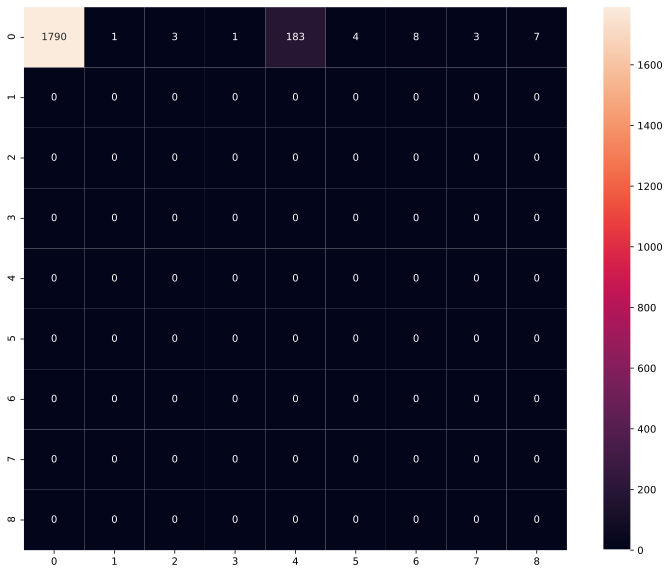

In [33]:
cm = confusion_matrix(test_labels,predictions_labels)
fig, ax = plt.subplots(figsize=(13,10)) 
sns.heatmap(cm,annot = True, square = True,ax = ax,fmt = "d")



In [ ]:
model_filter16_s3_adam_l3_d02.save('model_filter16_s3_adam_l3_d02')

INFO:tensorflow:Assets written to: model_filter16_s3_adam_l3_d02/assets


In [27]:
%config InlineBackend.figure_format = 'svg'
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

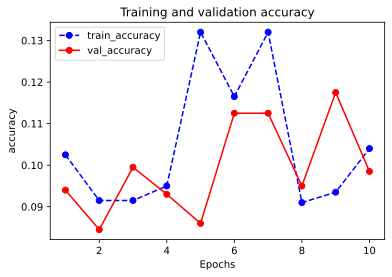

In [28]:
plot_metric(history,'accuracy')

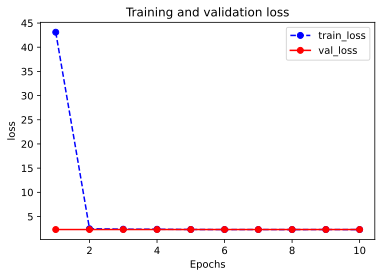

In [29]:
plot_metric(history,'loss')

In [ ]:
x_test = np.array(x_test,dtype = np.float64)/255
y_test = ohe.transform(y_test).toarray()

In [ ]:
model_filter16_s3_adam_l3_d02.evaluate(x_test)


## TRANSFER LEARNING


In [ ]:
model_res = ResNet50(include_top= False,weights = "imagenet",input_shape=(224,224,3))
output = model_res.output
model_res1 = Flatten()(output)
model_res1 = Dense(1024,activation = "relu")(model_res1)
model_res1 = Dense(10,activation = "softmax")(model_res1)
new_model = Model(model_res.input,model_res1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_28[0][0]                   
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
for layer in new_model.layers[:-4]:
  layer.trainable = False
  

In [ ]:
new_model.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ["accuracy"])

In [ ]:
y_valid.shape

(2000, 10)

In [ ]:
history_transfer = new_model.fit(x_train,y_transformed,batch_size = 16, epochs = 10, validation_data=(x_valid,y_valid))

Epoch 1/10
125/125 [==============================] - 690s 6s/step - loss: 17.1034 - accuracy: 0.1063 - val_loss: 2.3044 - val_accuracy: 0.1000
Epoch 2/10
125/125 [==============================] - 680s 5s/step - loss: 2.3025 - accuracy: 0.1091 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/10
125/125 [==============================] - 684s 5s/step - loss: 2.3027 - accuracy: 0.0975 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 4/10
125/125 [==============================] - 687s 6s/step - loss: 2.3026 - accuracy: 0.1076 - val_loss: 2.3026 - val_accuracy: 0.1010
Epoch 5/10
125/125 [==============================] - 686s 6s/step - loss: 2.3028 - accuracy: 0.0955 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 6/10
125/125 [==============================] - 686s 6s/step - loss: 2.3027 - accuracy: 0.1010 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 7/10
125/125 [==============================] - 691s 6s/step - loss: 2.3027 - accuracy: 0.1013 - val_loss: 2.3026 - val_accuracy: 0.100

In [ ]:
new_model.save('resnet50_adam')


INFO:tensorflow:Assets written to: resnet50_adam/assets


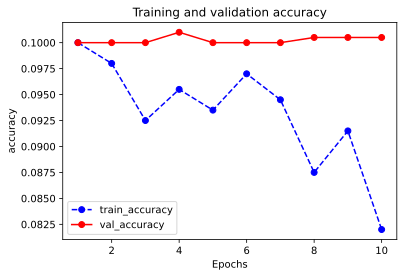

In [ ]:
plot_metric(history_transfer,'accuracy')

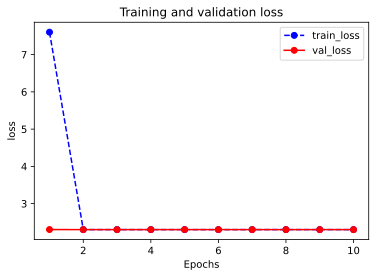

In [ ]:
plot_metric(history_transfer,'loss')

In [ ]:
new_model.evaluate(x_test,y_test)

In [37]:
model_res = VGG16(include_top= False,weights = "imagenet",input_shape=(224,224,3))
output = model_res.output
model_res1 = Flatten()(output)
model_res1 = Dense(1024,activation = "relu")(model_res1)
model_res1 = Dense(10,activation = "softmax")(model_res1)
new_model = Model(model_res.input,model_res1)

58892288/58889256 [==============================] - 0s 0us/step


In [38]:
for layer in new_model.layers[:-4]:
  layer.trainable = False

new_model.compile(loss = "categorical_crossentropy",optimizer = "adam",metrics = ["accuracy"])

In [39]:
history_transfer = new_model.fit(x_train,y_transformed,batch_size = 16, epochs = 10, validation_data=(x_valid,y_valid))

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 31.4733 - accuracy: 0.3864

KeyboardInterrupt: ignored